# 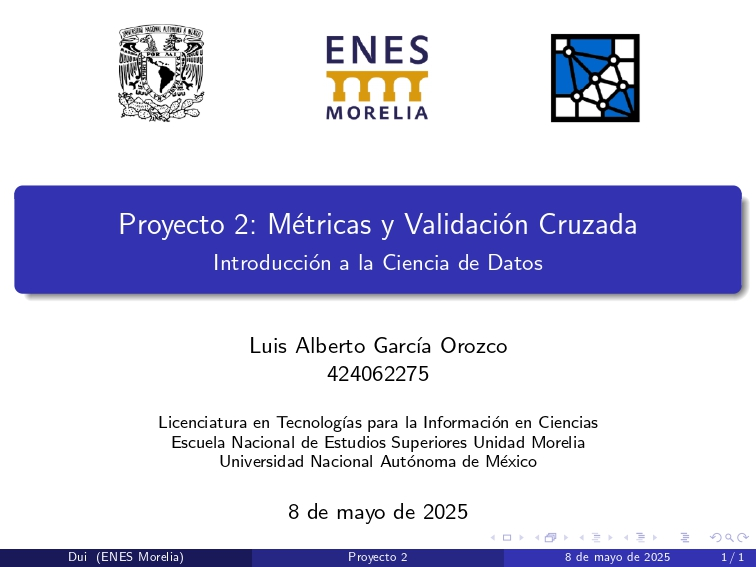

# Importaciones y funciones

En esta sección se importara lo necesario para el proyecto, y se prepararan las variables principales como la que almacena la base de datos, así como también se preparan funciones que se usaran.

In [60]:
import numpy as np                # Estas son las librerias principales para el
import pandas as pd               # Data Wrangling
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import classification_report # Librerias para el CV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC                       # Librerias de los modelos
from sklearn.tree import DecisionTreeClassifier

import warnings                   # Importamos warnings para evitar outputs demasiado grandes
warnings.filterwarnings("ignore")

filename = 'cia_paises.xlsx'      # Se almacena la base de datos como "df"
df = pd.read_excel(filename)
df

,Name,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,Taxes (% of GDP),External Debt (USD),Exchange Rate (USD),Internet Users,Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
0,Afghanistan,Asia,652230,37466414,2065,23.90,23.90,7.0,7.8700,4.717013e+06,13.50,46.0,34903.0,1.20
1,Akrotiri,Middle East,123,18195,0,NaN,NaN,NaN,0.8850,NaN,NaN,1.0,NaN,NaN
2,Albania,Europe,28748,3088385,13965,5.83,5.83,71.8,102.4300,2.196613e+06,71.85,3.0,3945.0,1.30
3,Algeria,Africa,2381740,43576691,11511,11.70,11.70,27.5,131.0850,2.481953e+07,59.58,149.0,104000.0,6.00
4,American Samoa,Oceania,224,46366,11200,29.80,29.80,12.2,1.0000,1.700000e+04,31.30,3.0,241.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,West Bank,Middle East,5860,2949246,6220,27.90,27.90,24.4,3.6060,2.673000e+06,57.40,2.0,4686.0,NaN
250,World,World,510.072 million sq km,7772850805,17500,7.70,7.70,67.2,NaN,3.960000e+09,51.00,41820.0,64285009.0,2.21
251,Yemen,Middle East,527968,30399243,2500,27.00,27.00,74.5,275.0000,7.659884e+06,26.72,57.0,71300.0,4.30
252,Zambia,Africa,752618,19077816,3470,15.00,15.00,63.1,21.0650,2.351646e+06,14.30,88.0,67671.0,1.20


In [2]:
def Report_to_dataframe(report):  # funcion para transformar los reportes de 
                                  # clasificación
    lines = [line.strip() for line in report.split('\n') if line.strip()]

    data = []
    columns = None
    index = []
    
    columns = lines[0].split()
    
    for line in lines:
        if line.startswith('accuracy'):
            parts = line.split()
            data.append([0,0] + parts[1:])
            index.append('accuracy')
        elif 'avg' in line:
            parts = line.split()
            avg_type = ' '.join(parts[:2])
            
            index.append(avg_type)
            data.append(parts[2:])
        elif line[0].isdigit() or (line.startswith('   ') and any(c.isdigit() for c in line)):
            parts = line.split()
            index.append('GDP ' + str(parts[0]))
            data.append(parts[1:])
    
    
    
    
    df = pd.DataFrame(data, columns=columns, index=index)
    for coloum in df.columns:
        df[coloum] = df[coloum].astype('float64')
    return df

# Data Wrangling
En esta sección se exploraran los datos y se dejaran listos para su uso en este proyecto.

In [3]:
df.info() ## primero revisamos por encima ver principalmente los tipos de
          ## de variable y donde hay valores faltantes.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 14 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Name                                     254 non-null    object 
 1   Continent                                254 non-null    object 
 2   Area (km²)                               254 non-null    object 
 3   Population                               254 non-null    object 
 4   GDP (USD)                                254 non-null    int64  
 5   Unemployment Rate                        220 non-null    float64
 6   Taxes (% of GDP)                         220 non-null    float64
 7   External Debt (USD)                      212 non-null    float64
 8   Exchange Rate (USD)                      239 non-null    float64
 9   Internet Users                           230 non-null    float64
 10  Internet Users Percentage of Population  230 non-n

## Datos atípicos
En esta sub-sección se localizan y se eliminan los datos atípicos de la base de datos
que fueron marcados en las instrucciones de la tarea

In [4]:
outliers_idx = df[df['GDP (USD)'] < 50].index

df.drop(outliers_idx, inplace = True)
df[df['GDP (USD)'] < 50]       

,Name,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,Taxes (% of GDP),External Debt (USD),Exchange Rate (USD),Internet Users,Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)


## Revisión de datos:

### Continent

Revisamos los valores unique aprovechando son pocos y eliminamos los absurdos como Word o European Union

In [5]:
col = 'Continent'
df[col].unique()

array(['Asia', 'Europe', 'Africa', 'Oceania',
       'Central America and the Caribbean', 'South America',
       'Middle East', 'North America', 'Southeast Asia', 'European Union',
       'Arctic Region', 'AsiaEurope', 'World'], dtype=object)

In [6]:
df[df[col] == 'World'].index, df[df[col] == 'European Union'].index

(Index([250], dtype='int64'), Index([77], dtype='int64'))

In [7]:
df = df.drop([250,77], axis = 0)
df[df[col] == 'World'], df[df[col] == 'European Union']

(Empty DataFrame
 Columns: [Name, Continent, Area (km²), Population, GDP (USD), Unemployment Rate, Taxes (% of GDP), External Debt (USD), Exchange Rate (USD), Internet Users, Internet Users Percentage of Population, Airports, Roadways (km), Militar Expenditures (% of GDP)]
 Index: [],
 Empty DataFrame
 Columns: [Name, Continent, Area (km²), Population, GDP (USD), Unemployment Rate, Taxes (% of GDP), External Debt (USD), Exchange Rate (USD), Internet Users, Internet Users Percentage of Population, Airports, Roadways (km), Militar Expenditures (% of GDP)]
 Index: [])

In [8]:
df[df[col] == 'Arctic Region']

,Name,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,Taxes (% of GDP),External Debt (USD),Exchange Rate (USD),Internet Users,Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
92,Greenland,Arctic Region,2166086,57799,41800,9.10,9.10,13.0,6.586,40084.0,69.48,15.0,0.0,NaN
106,Iceland,Arctic Region,103000,354234,55874,3.62,3.62,40.0,127.050,340117.0,99.01,96.0,12898.0,NaN


### Area (km²)	

Lo mismo hacemos para el área, que parece normal, que al ser del typo object pasamos
a float para poder visualizar el boxplot.

Notamos y checamos los datos atípicos separando los datos en 2 partes y ordenando cada una por
la columna que estamos revisando.

Revisamos manualmente unos datos en los extremos y los comparamos con los datos de https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_superficie.

Si los datos se asemejan los dejamos


In [9]:
col = 'Area (km²)'
df[col].unique()

array([652230, 28748, 2381740, 224, 468, 1246700, 91, 443, 2780400, 29743,
       180, 7741220, 83871, 86600, 13880, 760, 148460, 430, 207600, 30528,
       22966, 112622, 54, 38394, 1098581, 51197, 581730, 8515770, 151,
       5765, 110879, 274200, 676578, 27830, 4033, 181035, 475440, 9984670,
       264, 622984, 1.284, 756102, 9596960, 1138910, 2235, 2344858,
       342000, 236, 51100, 322463, 56594, 110860, 444, 9251, 78867, 43094,
       23200, 751, 48670, 283561, 1001450, 21041, 28051, 117600, 45228,
       17364, 1104300, 12173, 1393, 18274, 338145, 643801, 4167, 267667,
       11300, 69700, 357022, 238533, 7, 131957, 2166086, 344, 544, 108889,
       78, 245857, 36125, 214969, 27750, 112090, 1108, 93028, 103000,
       3287263, 1904569, 1648195, 438317, 70273, 572, 21937, 301340,
       10991, 377915, 116, 89342, 2724900, 580367, 811, 120538, 99720,
       10887, 17818, 199951, 236800, 64589, 10400, 30355, 111369, 1759540,
       160, 65300, 2586, 28, 587041, 118484, 329847, 298

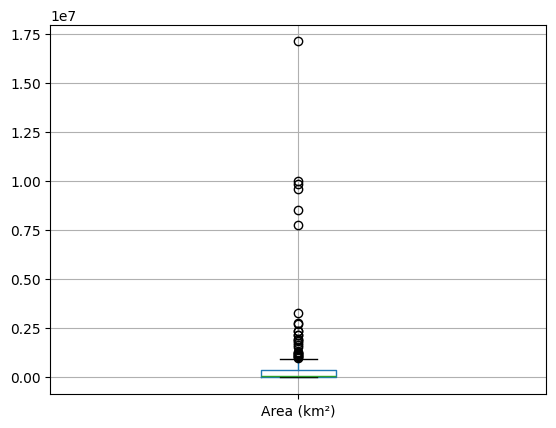

In [10]:
df[col] = df[col].astype('float64')
df.loc[:,[col]].boxplot()
plt.show()

In [11]:
df[df[col] > 0.1e7].sort_values(col).loc[:,['Name',col]]

,Name,Area (km²)
70,Egypt,1001450.0
145,Mauritania,1030700.0
27,Bolivia,1098581.0
76,Ethiopia,1104300.0
51,Colombia,1138910.0
209,South Africa,1219090.0
142,Mali,1240192.0
6,Angola,1246700.0
178,Peru,1285216.0
151,Mongolia,1564116.0


In [12]:
df[df[col] < 0.1e7].sort_values(col).loc[:,['Name',col]].head(10)

,Name,Area (km²)
164,Niger,1.267
45,Chad,1.284
150,Monaco,2.000
90,Gibraltar,7.000
227,Tokelau,12.000
157,Nauru,21.000
234,Tuvalu,26.000
137,Macau,28.000
204,Sint Maarten,34.000
192,Saint Martin,54.000


niger area = 1267000.0

chad area = 1284000.0

Fuentes: https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_superficie

In [13]:
df.loc[[164, 45],[col]] *= int(1e6)
df.loc[[164, 45],[col]]

,Area (km²)
164,1267000.0
45,1284000.0


### Population

El mismo proceso de Area (km²), si se hace algo diferente se denotará en cada columna.

En esta columna usaremos el tipo de dato como int, pero para comfirmar que no se cambie nada, primero compararemos las versiones int y float.

In [14]:
col = 'Population'
df[df[col].astype('int') != df[col].astype('float')]

,Name,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,Taxes (% of GDP),External Debt (USD),Exchange Rate (USD),Internet Users,Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
238,United Kingdom,Europe,243610.0,67.081,46659,3.17,3.17,87.5,0.7836,61784878.0,94.9,460.0,394428.0,2.32


United Kingdom population = 69611000
Fuentes: https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_y_territorios_dependientes_por_poblaci%C3%B3n

In [15]:
df.loc[238,[col]] *= int(1e6) # suponiendo un error de dedo,
df.loc[238,[col]]             # queriendo poner 6708100

Population    67081000.0
Name: 238, dtype: object

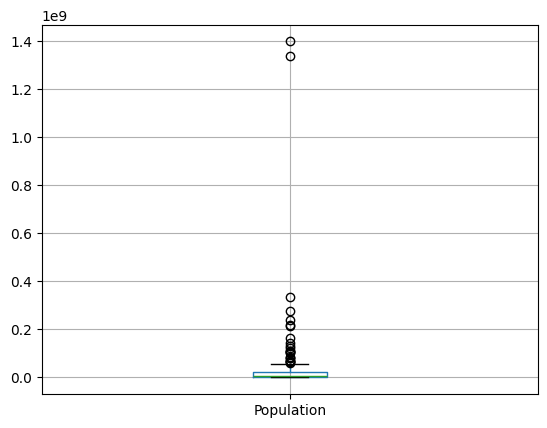

In [16]:
df[col] = df[col].astype('int')
df.loc[:,[col]].boxplot()
plt.show()

In [17]:
df[df[col] > 0.05e9].sort_values(col).loc[:,['Name',col]].tail(5)

,Name,Population
172,Pakistan,238181034
108,Indonesia,275122131
239,United States,334998398
107,India,1339330514
47,China,1397897720


### Taxes (% of GDP)

Esta columna se parece a la anterior, comparamos para ver que si son distintas.

Vemos que además de los valores NaN, solo en una ocación es reamente distinta, lo cual no le da información relevante a los modelos de aprendizaje, por lo que se eliminará

In [18]:
df[df[col] != df['Unemployment Rate']]

,Name,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,Taxes (% of GDP),External Debt (USD),Exchange Rate (USD),Internet Users,Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
0,Afghanistan,Asia,652230.0,37466414,2065,23.90,23.90,7.0,7.8700,4717013.0,13.50,46.0,34903.0,1.2
2,Albania,Europe,28748.0,3088385,13965,5.83,5.83,71.8,102.4300,2196613.0,71.85,3.0,3945.0,1.3
3,Algeria,Africa,2381740.0,43576691,11511,11.70,11.70,27.5,131.0850,24819531.0,59.58,149.0,104000.0,6.0
4,American Samoa,Oceania,224.0,46366,11200,29.80,29.80,12.2,1.0000,17000.0,31.30,3.0,241.0,NaN
5,Andorra,Europe,468.0,85645,49900,3.70,3.70,41.0,0.8850,78483.0,91.57,NaN,320.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,Wallis and Futuna,Oceania,142.0,15851,3800,8.80,8.80,5.6,110.2000,3450.0,22.10,2.0,NaN,NaN
249,West Bank,Middle East,5860.0,2949246,6220,27.90,27.90,24.4,3.6060,2673000.0,57.40,2.0,4686.0,NaN
251,Yemen,Middle East,527968.0,30399243,2500,27.00,27.00,74.5,275.0000,7659884.0,26.72,57.0,71300.0,4.3
252,Zambia,Africa,752618.0,19077816,3470,15.00,15.00,63.1,21.0650,2351646.0,14.30,88.0,67671.0,1.2


In [19]:
df = df.drop('Taxes (% of GDP)', axis = 1)

### Internet Users	&& Internet Users Percentage of Population

Para estas dos lo que noto es que dan información similar, y uno se puede calcular con información ya antes dada.

Otra cosa que se puede ver es que uno de ellos tiene datos atipicos y el otro no.
Y tambien noté que la versión calculada se parece a la almacenana en la mayoria de los casos.

Debido a lo aterior remplazamos la que se puede calcular con los calculos, y eliminamos la otra columna que da información similar pero con datos atípicos.

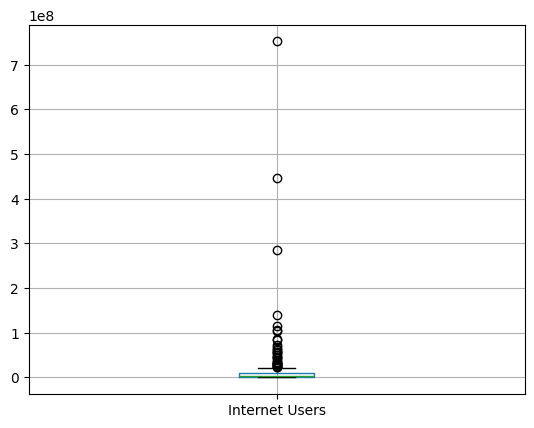

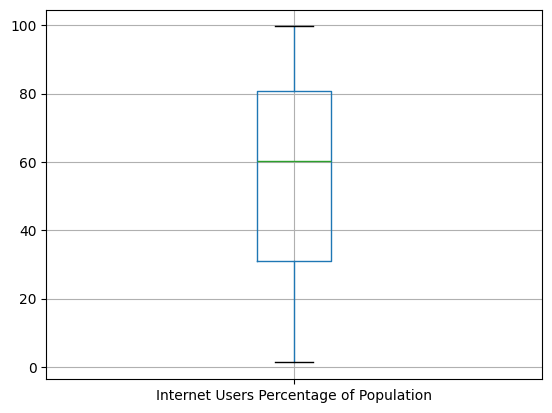

In [20]:
cols = 'Internet Users', 'Internet Users Percentage of Population'
df.loc[:,[cols[0]]].boxplot()
plt.show()
df.loc[:,[cols[1]]].boxplot()
plt.show()

In [21]:
diferencias = df[cols[0]]/df['Population']*100 - df[cols[1]]
diferencias

0      -0.910023
2      -0.725027
3      -2.624021
4       5.364797
5       0.067574
         ...    
248    -0.334812
249    33.233335
251    -1.522386
252    -1.973400
253    -1.459049
Length: 227, dtype: float64

In [22]:
diferencias[abs(diferencias) > 5]

4       5.364797
18     -5.443853
26     -5.107421
89     -5.144622
130    12.462498
136    -5.132997
166   -37.100000
193     5.070569
227   -11.323254
249    33.233335
dtype: float64

In [23]:
df[cols[1]] = df[cols[0]]/df['Population']*100

In [24]:
df = df.drop(cols[0], axis = 1)
df

,Name,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,External Debt (USD),Exchange Rate (USD),Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
0,Afghanistan,Asia,652230.0,37466414,2065,23.90,7.0,7.8700,12.589977,46.0,34903.0,1.2
2,Albania,Europe,28748.0,3088385,13965,5.83,71.8,102.4300,71.124973,3.0,3945.0,1.3
3,Algeria,Africa,2381740.0,43576691,11511,11.70,27.5,131.0850,56.955979,149.0,104000.0,6.0
4,American Samoa,Oceania,224.0,46366,11200,29.80,12.2,1.0000,36.664797,3.0,241.0,NaN
5,Andorra,Europe,468.0,85645,49900,3.70,41.0,0.8850,91.637574,NaN,320.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
248,Wallis and Futuna,Oceania,142.0,15851,3800,8.80,5.6,110.2000,21.765188,2.0,NaN,NaN
249,West Bank,Middle East,5860.0,2949246,6220,27.90,24.4,3.6060,90.633335,2.0,4686.0,NaN
251,Yemen,Middle East,527968.0,30399243,2500,27.00,74.5,275.0000,25.197614,57.0,71300.0,4.3
252,Zambia,Africa,752618.0,19077816,3470,15.00,63.1,21.0650,12.326600,88.0,67671.0,1.2


### Roadways (km)	

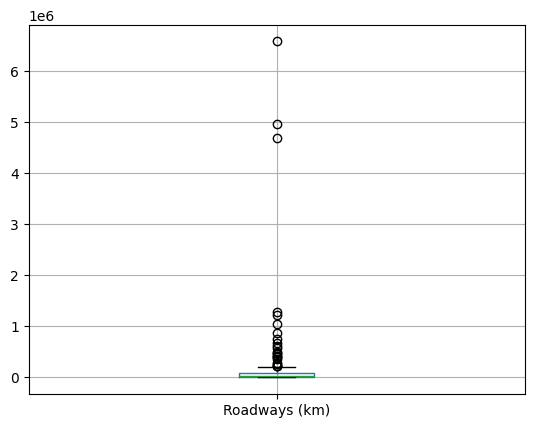

In [25]:
col = 'Roadways (km)'
df.loc[:,[col]].boxplot()
plt.show()

In [26]:
df[df[col] > 0.2e6].sort_values(col).loc[:,['Name',col]]

,Name,Roadways (km)
105,Hungary,203601.0
51,Colombia,206500.0
179,Philippines,216387.0
198,Saudi Arabia,221372.0
109,Iran,223485.0
172,Pakistan,263775.0
10,Argentina,281290.0
19,Bangladesh,369105.0
238,United Kingdom,394428.0
147,Mexico,398148.0


In [27]:
df[df[col] <= 0.2e6].sort_values(col).loc[:,['Name',col]].head(10)

,Name,Roadways (km)
148,"Micronesia, Federated States of",0.0
92,Greenland,0.0
31,Brazil,2.0
234,Tuvalu,8.0
227,Tokelau,10.0
90,Gibraltar,29.0
157,Nauru,30.0
204,Sint Maarten,53.0
141,Maldives,93.0
193,Saint Pierre and Miquelon,117.0


Kilómetros de carretera de Brazil = 2000000

Fuentes: https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_kil%C3%B3metros_de_carretera

In [28]:
df.loc[[31],[col]] *= int(1e6)
df.loc[[31],[col]]

,Roadways (km)
31,2000000.0


### Nombre

El Nombre parece ser un valor único que no deveria tener algo que ver en la desición de si un país tiene un PIB alto, medio o bajo, por lo que se elimina

In [29]:
df['Name'].nunique() == df.shape[0]

True

In [30]:
df = df.drop('Name', axis = 1)
df

,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,External Debt (USD),Exchange Rate (USD),Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
0,Asia,652230.0,37466414,2065,23.90,7.0,7.8700,12.589977,46.0,34903.0,1.2
2,Europe,28748.0,3088385,13965,5.83,71.8,102.4300,71.124973,3.0,3945.0,1.3
3,Africa,2381740.0,43576691,11511,11.70,27.5,131.0850,56.955979,149.0,104000.0,6.0
4,Oceania,224.0,46366,11200,29.80,12.2,1.0000,36.664797,3.0,241.0,NaN
5,Europe,468.0,85645,49900,3.70,41.0,0.8850,91.637574,NaN,320.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
248,Oceania,142.0,15851,3800,8.80,5.6,110.2000,21.765188,2.0,NaN,NaN
249,Middle East,5860.0,2949246,6220,27.90,24.4,3.6060,90.633335,2.0,4686.0,NaN
251,Middle East,527968.0,30399243,2500,27.00,74.5,275.0000,25.197614,57.0,71300.0,4.3
252,Africa,752618.0,19077816,3470,15.00,63.1,21.0650,12.326600,88.0,67671.0,1.2


## Remplazar GDP por clasificación:

Ingreso bajo: $50 \le GDP \le 5000$

Ingreso medio: $5000 < GDP \le 25000$

Ingreso alto: $25000 < GDP$

In [31]:
ing_bajo_indx  = df[df['GDP (USD)'] <= 5000].index
ing_medio_indx = df[df['GDP (USD)'] <= 25000][df['GDP (USD)'] >  5000].index
ing_alto_indx  = df[df['GDP (USD)'] >  25000].index

df['GDP (USD)'][ing_bajo_indx]  = [1 for _ in range(len(ing_bajo_indx))] 
df['GDP (USD)'][ing_medio_indx] = [2 for _ in range(len(ing_medio_indx))] # Hacemos los
df['GDP (USD)'][ing_alto_indx]  = [3 for _ in range(len(ing_alto_indx))]   # cambios para
                                                                           # las clases

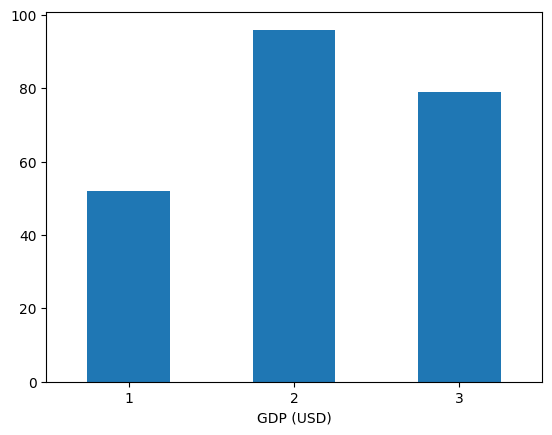

In [32]:
df['GDP (USD)'].value_counts().sort_index().plot(kind='bar', )
plt.xticks(rotation=0)
plt.show()

## Imputing

In [33]:
columnas_por_cambiar = []
for columna in df.columns:
    miss = df[columna].isnull().sum()
    if miss > 0:
        print(f'La columna {columna} tiene {miss} valores faltantes')
        columnas_por_cambiar.append(columna)
columnas_por_cambiar

La columna Unemployment Rate tiene 10 valores faltantes
La columna External Debt (USD) tiene 18 valores faltantes
La columna Internet Users Percentage of Population tiene 4 valores faltantes
La columna Airports tiene 5 valores faltantes
La columna Roadways (km) tiene 6 valores faltantes
La columna Militar Expenditures (% of GDP) tiene 62 valores faltantes


['Unemployment Rate',
 'External Debt (USD)',
 'Internet Users Percentage of Population',
 'Airports',
 'Roadways (km)',
 'Militar Expenditures (% of GDP)']

In [34]:
for columna in columnas_por_cambiar:
    media = df[columna].mean()
    df[columna].fillna(media, inplace = True)

## Reescripction

In [35]:
with open('cia_limpio.csv', 'w') as file:
    file.write(df.to_csv(index=False))         # Guardamos el archivo limpio para que los índices no 
                                               # sean un problema
df = pd.read_csv('cia_limpio.csv', )
df

,Continent,Area (km²),Population,GDP (USD),Unemployment Rate,External Debt (USD),Exchange Rate (USD),Internet Users Percentage of Population,Airports,Roadways (km),Militar Expenditures (% of GDP)
0,Asia,652230.0,37466414,1,23.90,7.0,7.8700,12.589977,46.000000,34903.000000,1.200000
1,Europe,28748.0,3088385,2,5.83,71.8,102.4300,71.124973,3.000000,3945.000000,1.300000
2,Africa,2381740.0,43576691,2,11.70,27.5,131.0850,56.955979,149.000000,104000.000000,6.000000
3,Oceania,224.0,46366,2,29.80,12.2,1.0000,36.664797,3.000000,241.000000,2.059212
4,Europe,468.0,85645,3,3.70,41.0,0.8850,91.637574,185.144144,320.000000,2.059212
...,...,...,...,...,...,...,...,...,...,...,...
222,Oceania,142.0,15851,1,8.80,5.6,110.2000,21.765188,2.000000,167410.819005,2.059212
223,Middle East,5860.0,2949246,2,27.90,24.4,3.6060,90.633335,2.000000,4686.000000,2.059212
224,Middle East,527968.0,30399243,1,27.00,74.5,275.0000,25.197614,57.000000,71300.000000,4.300000
225,Africa,752618.0,19077816,1,15.00,63.1,21.0650,12.326600,88.000000,67671.000000,1.200000


# Validación cruzada

Para cada modelo se ajustara automáticamente con la funcion GridSearchCV y depués el modelo de mayor exactitud se someterá a otro CV manual que servira para recolectar el promedio del reporte de clasificación que se almacenara en un archivo csv para comparar

In [36]:
cv_spliter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state = 73)
y = df['GDP (USD)']
models = [SGDClassifier, SVC, DecisionTreeClassifier]

In [37]:
X = pd.get_dummies(df.drop('GDP (USD)', axis = 1))

## Pre-creación del archivo de comparación:

In [38]:
metricas = ['SGDClassifier', 'SVC', 'DecisionTreeClassifier']
with open('validacion_cruzada.csv', 'w') as vc:
    vc.write('Métrica,Exactitud,Presición,Sensivilidad,F1\n')
    for i in range(3):
        vc.write(f'Métrica {i+1}: {metricas[i]}' + ','*4 + '\n')

comparison_df = pd.read_csv('validacion_cruzada.csv')
comparison_df

,Métrica,Exactitud,Presición,Sensivilidad,F1
0,Métrica 1: SGDClassifier,NaN,NaN,NaN,NaN
1,Métrica 2: SVC,NaN,NaN,NaN,NaN
2,Métrica 3: DecisionTreeClassifier,NaN,NaN,NaN,NaN


## SGDClassifier

### Param selection

In [67]:
indx = 0

param_grid = {
    'loss': ['log_loss', 'hinge', 'squared_hinge'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'max_iter': [100, 500, 1000],
    'learning_rate': ['constant', 'invscaling'],
    'eta0': [0.01, 0.1, 0.2, 1, 0.001, 0.0001],
    'l1_ratio': [0.1, 0.5, 0.9],
    'tol': [1e-4,1e-3]
}
model = models[indx]
grid_search = GridSearchCV(model(), param_grid, cv = 5, scoring = 'accuracy', n_jobs=-1)

In [68]:
grid_search.fit(X, y)

/home/dui/venv/intro_ds/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dui/venv/intro_ds/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dui/venv/intro_ds/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dui/venv/intro_ds/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/dui/venv/intro

GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'eta0': [0.01, 0.1, 0.2, 1, 0.001, 0.0001],
                         'l1_ratio': [0.1, 0.5, 0.9],
                         'learning_rate': ['constant', 'invscaling'],
                         'loss': ['log_loss', 'hinge', 'squared_hinge'],
                         'max_iter': [100, 500, 1000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'tol': [0.0001, 0.001]},
             scoring='accuracy')

In [69]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')[['params']]

,params
3399,"{'alpha': 0.0001, 'eta0': 0.001, 'l1_ratio': 0..."
5153,"{'alpha': 0.001, 'eta0': 1, 'l1_ratio': 0.9, '..."
7359,"{'alpha': 0.01, 'eta0': 0.001, 'l1_ratio': 0.9..."
3359,"{'alpha': 0.0001, 'eta0': 0.001, 'l1_ratio': 0..."
5889,"{'alpha': 0.01, 'eta0': 0.01, 'l1_ratio': 0.1,..."
...,...
5573,"{'alpha': 0.001, 'eta0': 0.0001, 'l1_ratio': 0..."
8790,"{'alpha': 0.1, 'eta0': 1, 'l1_ratio': 0.1, 'le..."
9182,"{'alpha': 0.1, 'eta0': 0.001, 'l1_ratio': 0.5,..."
3232,"{'alpha': 0.0001, 'eta0': 1, 'l1_ratio': 0.9, ..."


In [65]:
best_mod_v = grid_search.best_estimator_

### Manual CV

In [66]:
from sklearn.base import clone

reports = []

for train_index, test_index in cv_spliter.split(X, y):
    clone_clf = clone(best_mod_v)
    
    X_train_folds = X.iloc[train_index]
    y_train_folds = (y[train_index])
    X_test_fold = X.iloc[test_index]
    y_test_fold = (y[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    report = classification_report(y_test_fold, y_pred)
    report_df = Report_to_dataframe(report)
    reports.append(report_df)

mean_report = reports[0]
for report in reports[1:]: 
    mean_report += report
mean_report /= len(reports)
mean_report

,precision,recall,f1-score,support
GDP 1,0.000,0.000,0.000,11.0
GDP 2,0.374,0.836,0.516,19.0
GDP 3,0.441,0.199,0.192,16.0
accuracy,0.000,0.000,0.414,46.0
macro avg,0.272,0.344,0.236,46.0
weighted avg,0.307,0.414,0.281,46.0


In [44]:
acc = mean_report.loc['accuracy','f1-score']
precision, recall, f1, _ = mean_report.loc['weighted avg']

acc, precision, recall, f1

(np.float64(0.417), 0.304, 0.417, 0.278)

In [45]:
comparison_df.iloc[indx, 1:] = acc, precision, recall, f1
comparison_df

,Métrica,Exactitud,Presición,Sensivilidad,F1
0,Métrica 1: SGDClassifier,0.417,0.304,0.417,0.278
1,Métrica 2: SVC,NaN,NaN,NaN,NaN
2,Métrica 3: DecisionTreeClassifier,NaN,NaN,NaN,NaN


In [46]:
indx += 1

## SVC

### Param selection

In [47]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
    'coef0': [-0.5, 0.0, 0.5],
    'shrinking': [True, False],
    'class_weight': [None, 'balanced']
}
model = models[indx]
grid_search = GridSearchCV(model(), param_grid, cv = 5, error_score = 'raise', scoring = 'accuracy', n_jobs =- 1)

In [48]:
grid_search.fit(X, y)

best_mod_v = grid_search.best_estimator_
best_mod_v

SVC(C=0.01, coef0=-0.5)

### Manual CV

In [49]:
from sklearn.base import clone

reports = []

for train_index, test_index in cv_spliter.split(X, y):
    clone_clf = clone(best_mod_v)
    
    X_train_folds = X.iloc[train_index]
    y_train_folds = (y[train_index])
    X_test_fold = X.iloc[test_index]
    y_test_fold = (y[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    report = classification_report(y_test_fold, y_pred)
    report_df = Report_to_dataframe(report)
    reports.append(report_df)

mean_report = reports[0]
for report in reports[1:]: 
    mean_report += report
mean_report /= len(reports)
mean_report

,precision,recall,f1-score,support
GDP 1,0.00,0.00,0.00,11.0
GDP 2,0.41,1.00,0.58,19.0
GDP 3,0.00,0.00,0.00,16.0
accuracy,0.00,0.00,0.41,46.0
macro avg,0.14,0.33,0.19,46.0
weighted avg,0.17,0.41,0.24,46.0


In [50]:
acc = mean_report.loc['accuracy','f1-score']
precision, recall, f1, _ = mean_report.loc['weighted avg']

acc, precision, recall, f1

(np.float64(0.41000000000000003),
 0.16999999999999998,
 0.41000000000000003,
 0.24000000000000005)

In [51]:
comparison_df.iloc[indx, 1:] = acc, precision, recall, f1
comparison_df

,Métrica,Exactitud,Presición,Sensivilidad,F1
0,Métrica 1: SGDClassifier,0.417,0.304,0.417,0.278
1,Métrica 2: SVC,0.410,0.170,0.410,0.240
2,Métrica 3: DecisionTreeClassifier,NaN,NaN,NaN,NaN


In [52]:
indx += 1

## Decision Trees

### Param selection

In [53]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2', 0.5],
    'max_leaf_nodes': [None, 10, 30, 100],
    'class_weight': [None, 'balanced']
}
model = models[indx]
grid_search = GridSearchCV(model(), param_grid, cv = 5, error_score = 'raise', scoring = 'accuracy', n_jobs =- 1)

In [54]:
grid_search.fit(X, y)

best_mod_v = grid_search.best_estimator_
best_mod_v

DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=0.5,
                       max_leaf_nodes=30, min_samples_leaf=2,
                       min_samples_split=5)

### Manual CV

In [55]:
reports = []

for train_index, test_index in cv_spliter.split(X, y):
    clone_clf = clone(best_mod_v)
    
    X_train_folds = X.iloc[train_index]
    y_train_folds = (y[train_index])
    X_test_fold = X.iloc[test_index]
    y_test_fold = (y[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    
    report = classification_report(y_test_fold, y_pred)
    report_df = Report_to_dataframe(report)
    reports.append(report_df)

mean_report = reports[0]
for report in reports[1:]: 
    mean_report += report
mean_report /= len(reports)
mean_report

,precision,recall,f1-score,support
GDP 1,0.738,0.720,0.708,11.0
GDP 2,0.678,0.667,0.667,19.0
GDP 3,0.797,0.789,0.790,16.0
accuracy,0.000,0.000,0.721,46.0
macro avg,0.737,0.725,0.722,46.0
weighted avg,0.733,0.721,0.721,46.0


In [56]:
acc = mean_report.loc['accuracy','f1-score']
precision, recall, f1, _ = mean_report.loc['weighted avg']

acc, precision, recall, f1

(np.float64(0.7210000000000001), 0.733, 0.7210000000000001, 0.7210000000000001)

In [57]:
comparison_df.iloc[indx, 1:] = acc, precision, recall, f1
comparison_df

,Métrica,Exactitud,Presición,Sensivilidad,F1
0,Métrica 1: SGDClassifier,0.417,0.304,0.417,0.278
1,Métrica 2: SVC,0.410,0.170,0.410,0.240
2,Métrica 3: DecisionTreeClassifier,0.721,0.733,0.721,0.721


# Conclución



In [59]:
comparison_df

,Métrica,Exactitud,Presición,Sensivilidad,F1
0,Métrica 1: SGDClassifier,0.417,0.304,0.417,0.278
1,Métrica 2: SVC,0.410,0.170,0.410,0.240
2,Métrica 3: DecisionTreeClassifier,0.721,0.733,0.721,0.721


Claramente el modelo de DecisionTreeClassifier dominó por completo, aunque aun tiene valores algo bajos